In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM  # For HMM modeling


# =============================================================================
# 1. DATA IMPORT AND PREPROCESSING
# =============================================================================

In [4]:

# Read in the updated dataset (assumed comma-separated)
# Data was acquired from https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption
# A small subset of data was taken and anomalies were inserted
df = pd.read_csv("data/Selected_Individual_Household_Electric_Power_Consumption.txt", sep=",", header=0)

# Create a Date_time column from Date and Time
df['Date_time'] = pd.to_datetime(df['Date'] + " " + df['Time'], format="%d/%m/%Y %H:%M:%S")

# Convert Date column to datetime so that we can extract weekday information.
df['Date_dt'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# In Python, .dt.weekday returns 0 for Monday, so we adjust:
# (weekday + 1) % 7 makes Sunday = 0.
df['Day_Numbered'] = (df['Date_dt'].dt.weekday + 1) % 7

In [5]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date_time,Date_dt,Day_Numbered
0,16/12/2006,17:24:00,5.36000,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,2006-12-16,6
1,16/12/2006,17:25:00,5.36000,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,2006-12-16,6
2,16/12/2006,17:26:00,5.37400,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,2006-12-16,6
3,16/12/2006,17:27:00,5.38800,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,2006-12-16,6
4,16/12/2006,17:28:00,4.45400,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,2006-12-16,6
...,...,...,...,...,...,...,...,...,...,...,...,...
1556439,1/12/2009,14:03:00,0.68000,0.298,243.55,3.0,0.0,0.0,0.0,2009-12-01 14:03:00,2009-12-01,2
1556440,1/12/2009,14:04:00,0.65765,0.200,245.19,2.6,0.0,0.0,1.0,2009-12-01 14:04:00,2009-12-01,2
1556441,1/12/2009,14:05:00,0.43400,0.106,246.02,1.8,0.0,0.0,1.0,2009-12-01 14:05:00,2009-12-01,2
1556442,1/12/2009,14:06:00,0.42800,0.106,245.86,1.8,0.0,0.0,0.0,2009-12-01 14:06:00,2009-12-01,2



# =============================================================================
# 2. PRINCIPAL COMPONENT ANALYSIS (PCA)
# =============================================================================

In [25]:

# Filter for Mondays (Day_Numbered == 1, which in our conversion corresponds to Monday)
# and for times from "12:00:00" (noon) to "24:00:00".
mask = (df['Day_Numbered'] == 1) & (df['Time'] >= "12:00:00") & (df['Time'] < "24:00:00")
PCA_dataset = df.loc[mask].copy()

In [ ]:

# Get unique Monday dates (here we simply use unique values in the Date column)
monday_dates = PCA_dataset['Date'].unique()

# For each Monday, calculate the mean of the response variables.
avg_list = []
for d in monday_dates:
    temp = PCA_dataset[PCA_dataset['Date'] == d]
    # For example, suppose our response variables are in columns named:
    # ['Global_intensity','Global_active_power','Voltage','Sub_metering_1',
    #  'Sub_metering_2','Sub_metering_3','Some_other_response']
    responses = temp.iloc[:, 3:10]
    avg_vals = responses.mean()
    avg_vals['Date'] = d
    avg_list.append(avg_vals)

all_mondays_avg = pd.DataFrame(avg_list)

In [ ]:
# Perform PCA on the averaged response values (using only numeric columns)
features = all_mondays_avg.select_dtypes(include=[np.number]).values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA()
pca_components = pca.fit_transform(features_scaled)

# Create a simple biplot (here only showing the scores on PC1 and PC2)
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c='blue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot (Scores Only)")
plt.show()


/var/folders/wr/9myd_k6j56550846xfdfvfdw0000gn/T/ipykernel_16598/1209914981.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pcs, y=explained_var,
/var/folders/wr/9myd_k6j56550846xfdfvfdw0000gn/T/ipykernel_16598/1209914981.py:5: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(x=pcs, y=explained_var,


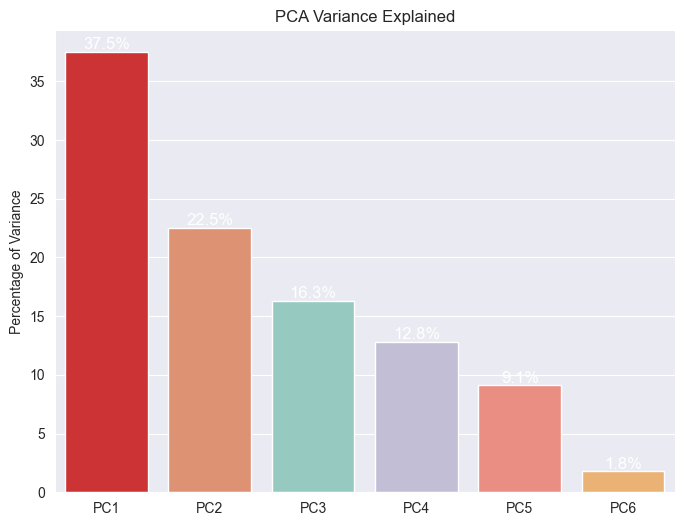

In [28]:

# Plotting the percentage of variance explained by each PC as a bar plot.
explained_var = 100 * pca.explained_variance_ratio_
pcs = [f"PC{i+1}" for i in range(len(explained_var))]
plt.figure(figsize=(8, 6))
sns.barplot(x=pcs, y=explained_var,
            palette=["#e41a1c", "#ef8a62", "#8dd3c7", "#bebada", "#fb8072", "#fdb462", "#4d4d4d"])
for i, perc in enumerate(explained_var):
    plt.text(i, perc, f"{perc:.1f}%", ha='center', va='bottom', color='white', fontsize=12)
plt.ylabel("Percentage of Variance")
plt.title("PCA Variance Explained")
plt.show()


# =============================================================================
# 3. TIME WINDOW SELECTION
# =============================================================================

In [ ]:

# Convert Date_time and Date to datetime objects (already done above)
# Define specific dates of interest:
dates_of_interest = {
    "Dec19_2006": pd.to_datetime("19/12/2006", format="%d/%m/%Y"),
    "Jan23_2007": pd.to_datetime("23/01/2007", format="%d/%m/%Y"),
    "Feb05_2008": pd.to_datetime("05/02/2008", format="%d/%m/%Y"),
    "Jun23_2009": pd.to_datetime("30/06/2009", format="%d/%m/%Y")
}

# Extract data for each date (here using the Date_dt column)
Data_Dec19 = df[df['Date_dt'] == dates_of_interest["Dec19_2006"]].copy()
Data_Jan23 = df[df['Date_dt'] == dates_of_interest["Jan23_2007"]].copy()
Data_Feb05 = df[df['Date_dt'] == dates_of_interest["Feb05_2008"]].copy()
Data_Jun23 = df[df['Date_dt'] == dates_of_interest["Jun23_2009"]].copy()

# For each, convert the Date_time to a “logic time” (minutes from the start of that day)
def compute_logic_time(series):
    start = series.iloc[0]
    return (series - start).dt.total_seconds() / 60

Data_Dec19['Logic_time'] = compute_logic_time(Data_Dec19['Date_time'])
Data_Jan23['Logic_time'] = compute_logic_time(Data_Jan23['Date_time'])
Data_Feb05['Logic_time'] = compute_logic_time(Data_Feb05['Date_time'])
Data_Jun23['Logic_time'] = compute_logic_time(Data_Jun23['Date_time'])

# Example: Plot Global_intensity vs Logic_time for December 19, 2006
plt.figure(figsize=(8, 6))
sc = plt.scatter(Data_Dec19['Logic_time'], Data_Dec19['Global_intensity'],
                 c=Data_Dec19['Global_intensity'], cmap="viridis", s=10)
plt.colorbar(sc, label="Global Intensity")
plt.xlabel("Logic Time (minutes)")
plt.ylabel("Global Intensity")
plt.title("Time vs Global Intensity (19 December 2006)")
plt.xlim(0, 1440)
plt.show()


# =============================================================================
# 4. SIMPLE ANOMALY DETECTION USING MOVING AVERAGE
# =============================================================================

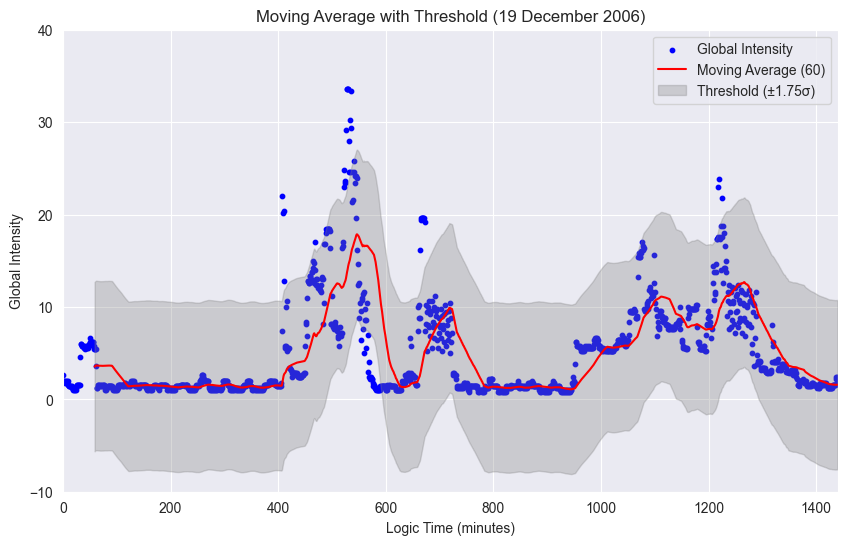

In [76]:

# Example: compute a 60-point moving average for Global_intensity for December 19, 2006.
# (Make sure Data_Dec19 is sorted by Date_time.)
Data_Dec19 = Data_Dec19.sort_values('Date_time')
Data_Dec19['Moving_Average_60'] = Data_Dec19['Global_intensity'].rolling(window=60, min_periods=60).mean()

# Compute the standard deviation for Global_intensity on this day.
std_dec19 = Data_Dec19['Global_intensity'].std()

# Plot Global_intensity, moving average, and thresholds (here threshold = ±1.75*std).
plt.figure(figsize=(10, 6))
plt.scatter(Data_Dec19['Logic_time'], Data_Dec19['Global_intensity'], s=10, color='blue', label='Global Intensity')
plt.plot(Data_Dec19['Logic_time'], Data_Dec19['Moving_Average_60'], color='red', linewidth=1.5, label='Moving Average (60)')
plt.fill_between(Data_Dec19['Logic_time'],
                 Data_Dec19['Moving_Average_60'] - 1.75*std_dec19,
                 Data_Dec19['Moving_Average_60'] + 1.75*std_dec19,
                 color='gray', alpha=0.3, label='Threshold (±1.75σ)')
plt.xlabel("Logic Time (minutes)")
plt.ylabel("Global Intensity")
plt.title("Moving Average with Threshold (19 December 2006)")
plt.legend()
plt.xlim(0, 1440)
plt.ylim(-10, 40)
plt.show()


# =============================================================================
# 5. GLOBAL ENVIRONMENT SETUP: SPLITTING TRAINING AND TESTING DATA
# =============================================================================

In [71]:

# Define training start and end dates
training_start = pd.to_datetime("16/12/2006", format="%d/%m/%Y")
training_end = pd.to_datetime("30/11/2008", format="%d/%m/%Y")

# Create a boolean mask for training data
mask_train = (df['Date_dt'] >= training_start) & (df['Date_dt'] <= training_end)

# Create time-of-day masks for different datasets:
early_mask   = (df['Time'] >= "04:00:00") & (df['Time'] < "08:00:00")
afternoon_mask = (df['Time'] >= "12:00:00") & (df['Time'] < "17:00:00")
night_mask   = (df['Time'] >= "20:00:00") & (df['Time'] < "24:00:00")

early_morning_dataset = df[mask_train & early_mask].copy()
afternoon_dataset     = df[mask_train & afternoon_mask].copy()
night_dataset         = df[mask_train & night_mask].copy()

# (For column selection, in R a subset of columns was taken;
#  in Python you can select columns by name, e.g. early_morning_dataset = early_morning_dataset[["Date_time", "Global_intensity", ...]])


# =============================================================================
# 6. TRAINING AND TESTING HMM MODELS
# =============================================================================

In [72]:

# Here we show a univariate example using hmmlearn’s GaussianHMM.
# Note: R’s depmixS4 supports “ntimes” to indicate sequence breaks. In hmmlearn you can pass a list of sequence lengths.

# Prepare training sequences from early morning data.
# We assume that each unique Date (or day) in early_morning_dataset is a separate sequence.
train_sequences = []
lengths = []
for date, group in early_morning_dataset.groupby('Date'):
    seq = group['Global_intensity'].values.reshape(-1, 1)
    train_sequences.append(seq)
    lengths.append(len(seq))
X_train = np.concatenate(train_sequences)

## Below Code Will Run For ~ 30 Minutes

In [67]:

# Fit several HMMs with different numbers of states.
state_options = [4,8,12,16,18,20]
results = []
N = X_train.shape[0]
for n_states in state_options:
    model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100, random_state=1)
    model.fit(X_train, lengths)
    logL = model.score(X_train, lengths)
    # Rough parameter count for a Gaussian HMM (for 1-D data):
    # parameters = (n_states - 1) [initial prob] + n_states*(n_states - 1) [transitions]
    #              + n_states*2 [mean and variance per state]
    params = (n_states - 1) + n_states*(n_states - 1) + n_states * 2
    bic = -2 * logL + params * np.log(N)
    print('states: ', n_states, 'logL: ', logL, 'BIC:', bic)
    results.append({'states': n_states, 'logL': logL, 'BIC': bic})

states:  4 logL:  -174798.94138562042 BIC: 349875.09996495966
states:  8 logL:  -160976.23041396338 BIC: 322904.6416237436
states:  12 logL:  -9375.520390213644 BIC: 20763.8786652553
states:  16 logL:  -52397.233142910365 BIC: 108253.65474657307
states:  18 logL:  -58178.7814005985 BIC: 120684.56160750391
states:  20 logL:  198520.40867335448 BIC: -391749.58482311916


In [73]:
models_df = pd.DataFrame(results)
print(models_df)

   states           logL            BIC
0       4 -174798.941386  349875.099965
1       8 -160976.230414  322904.641624
2      12   -9375.520390   20763.878665
3      16  -52397.233143  108253.654747
4      18  -58178.781401  120684.561608
5      20  198520.408673 -391749.584823


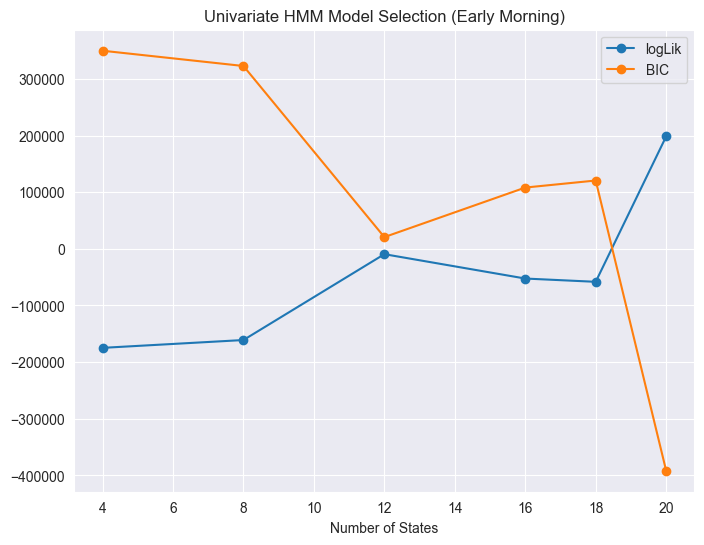

In [74]:
# Plot log-likelihood and BIC against number of states.
plt.figure(figsize=(8, 6))
plt.plot(models_df['states'], models_df['logL'], marker='o', label='logLik')
plt.plot(models_df['states'], models_df['BIC'], marker='o', label='BIC')
plt.xlabel("Number of States")
plt.legend()
plt.title("Univariate HMM Model Selection (Early Morning)")
plt.show()

# (A similar approach would be used for multivariate models
#  – for example, stacking columns ['Global_intensity', 'Global_active_power', 'Sub_metering_3'] into a 2D array
#  and setting n_features=3 when initializing GaussianHMM.)

# For testing, you would load the test data (e.g., EM_test_data) similarly and then use model.score(test_X, test_lengths)
# to compare normalized log-likelihoods.

# From the Log-Likelihood and BIC graph 12 states seems to be optimal

In [77]:
model = GaussianHMM(n_components=12, covariance_type="full", n_iter=100, random_state=1)
model.fit(X_train, lengths)

GaussianHMM(covariance_type='full', n_components=12, n_iter=100, random_state=1)

# =============================================================================
# 7. ANOMALY DETECTION USING THE HMM
# =============================================================================
# 7.1. Prepare a test dataset (any data AFTER training_end, for example)

In [78]:

test_mask = (df['Date_dt'] > training_end) & early_mask  # early morning times after training
test_df = df[test_mask].copy()
test_df.sort_values('Date_time', inplace=True)

# If you have multiple days in test_df, you can handle them similarly
# or just illustrate with one day. For demonstration, let's keep them together.
test_df['Logic_time'] = test_df.groupby('Date')['Date_time'].transform(
    lambda x: (x - x.iloc[0]).dt.total_seconds()/60
)

# Convert to the shape (n_samples, 1)
X_test = test_df['Global_intensity'].values.reshape(-1, 1)

In [79]:
# 7.2. Get log probability per sample (emission-based) using score_samples
# Compute the log probability under the model and compute posteriors

# 1) Get total logprob and posterior matrix
logprob, posteriors = model.score_samples(X_test)
# logprob is float, posteriors is (n_samples, n_components)

# 2) Get emission log-likelihoods
emission_ll = model._compute_log_likelihood(X_test)  # shape (n_samples, n_components)

# 3) For each row i, combine them
sample_logprob = []
for i in range(len(X_test)):
    # Weighted sum of emission probabilities, using the posterior as weights
    # p(x_i) = sum_j [ posteriors[i,j] * exp(emission_ll[i,j]) ]
    # Then take log
    row_ll = np.log(np.sum(posteriors[i, :] * np.exp(emission_ll[i, :])))
    sample_logprob.append(row_ll)

# Now sample_logprob is length n_samples
test_df["log_prob"] = sample_logprob

In [80]:
# Step 4: pick two thresholds (upper & lower)
mean_lp = np.mean(sample_logprob)
std_lp  = np.std(sample_logprob)
k = 2.0

# For a symmetrical range around the mean:
lower_threshold = mean_lp - k*std_lp
upper_threshold = mean_lp + k*std_lp

# Anomaly if log_prob is < lower_threshold or > upper_threshold
test_df['anomaly'] = (test_df['log_prob'] < lower_threshold) | (test_df['log_prob'] > upper_threshold)

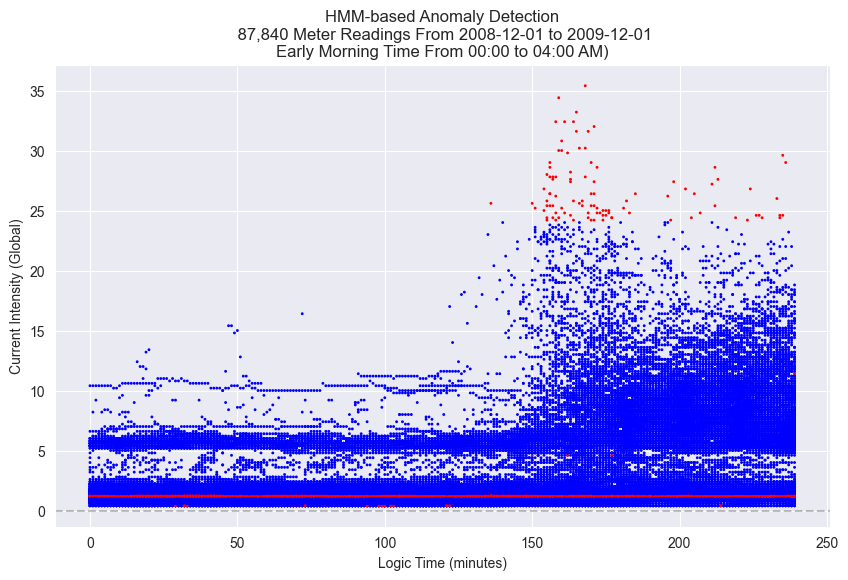

In [100]:

# 7.4. Plot the anomalies
plt.figure(figsize=(10, 6))
colors = np.where(test_df['anomaly'], 'red', 'blue')  # red=anomaly, blue=normal
plt.scatter(
    test_df['Logic_time'],
    test_df['Global_intensity'],
    c=colors,
    s=1.1
)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # optional
plt.title("HMM-based Anomaly Detection\n 87,840 Meter Readings From 2008-12-01 to 2009-12-01\nEarly Morning Time From 00:00 to 04:00 AM)")
plt.xlabel("Logic Time (minutes)")
plt.ylabel("Current Intensity (Global)")
plt.show()
